In [262]:
#get dataframe of tweet_id and user_id
import pandas as pd
import csv
from twython import Twython
import time
from collections import defaultdict

df = pandas.read_csv('gamergate_tweets.csv')
user_ids = df['user_id'].tolist()[:5000]

# Consumer & Auth keys and tokens for authentication
CONSUMER_KEY = "48r56upQvsnTiSDfY4CNwIpCQ"
CONSUMER_SECRET = "VqZhFW7GqogdKXJnpuS0umVe211bFgoCdaQlRdRMayvrbdDh3k"
OAUTH_TOKEN = "18000528-Scl8a1pLinqP4KWtaa3f8EN0M1vqAGTyYXMtsLIGm"
OAUTH_TOKEN_SECRET = "NcIvLeqVbwwBegabvo7946FVIaDN0CAaJ7aS2aV7pZFzC"

twitter = Twython(CONSUMER_KEY, CONSUMER_SECRET, OAUTH_TOKEN, OAUTH_TOKEN_SECRET)

# check rate limit
# twitter.get_application_rate_limit_status()['resources']['followers']

In [266]:
# Get followers/id 2
def test(twitter, user_id):
    follower_ids = []
    # Fetch the followings as a cursored collection (up to 5000 per call).
    cursor = -1
    #follower_ids = twitter.get_followers_ids(user_id=user_id, cursor=cursor)
    remaining = twitter.get_application_rate_limit_status()['resources']['followers']['/followers/ids']['remaining']
    while cursor != 0:
        if remaining < 2:
            print "start waiting ", cursor
            time.sleep(920)
            print "done waiting"
            twitter = Twython(CONSUMER_KEY, CONSUMER_SECRET, OAUTH_TOKEN, OAUTH_TOKEN_SECRET)
            remaining = twitter.get_application_rate_limit_status()['resources']['followers']['/followers/ids']['remaining']
            print remaining
        else:
            twitter = Twython(CONSUMER_KEY, CONSUMER_SECRET, OAUTH_TOKEN, OAUTH_TOKEN_SECRET)
            resp = twitter.get_followers_ids(user_id=user_id, cursor=cursor)
            follower_ids += resp['ids']
            cursor = resp['next_cursor']
            remaining = twitter.get_application_rate_limit_status()['resources']['followers']['/followers/ids']['remaining']
            print remaining
    return follower_ids

# GET followers/list
def get_follower_list(twitter, user_id):
    followers = []
    print twitter.get_application_rate_limit_status()['resources']['followers']['/followers/list']['remaining']
    cursored = twitter.cursor(twitter.get_followers_list, id=user_id)
    print twitter.get_application_rate_limit_status()['resources']['followers']['/followers/list']['remaining']
    for follower in cursored:
        followers.append(follower)
    return followers

# GET users/lookup
def get_user_lookup(twitter, current):
    user_obj = twitter.lookup_user(user_id=current)
    return user_obj
    
# GET followers/ids
def get_follower_ids(twitter, user_id):
    followers = []
    cursored = twitter.cursor(twitter.get_followers_ids, id=user_id)
    for follower in cursored:
        followers.append(follower)
    return followers

In [4]:
user_list = []
start = 0
end = 100
while end <= 5000:
    current = user_ids[start:end]
    start += 100
    end += 100
    users = get_user_lookup(twitter, current)
    for i in range(0, len(users)):
        each_user = []
        each_user.append(user_ids[i]) # user[0] = user_id
        each_user.append(users[i]['followers_count']) # user[1] = follower count
        each_user.append(users[i]['favourites_count'])
        each_user.append(users[i]['location'])
        user_list.append(each_user)

In [5]:
users_df = pandas.DataFrame(user_list, columns=["User ID", "Follower Count", "Favourites Count", "Location"])
tweets_df = pandas.read_csv("all_tweets.csv")
print tweets_df.info()
#print users_df.sort_values(["Follower Count", "Favourites Count",], ascending=[False, False])

<class 'pandas.core.frame.DataFrame'>
Int64Index: 429367 entries, 0 to 429366
Data columns (total 9 columns):
User ID        270866 non-null object
Retweets       270873 non-null float64
Favorites      270873 non-null float64
Has_url        270871 non-null float64
Mentions       270852 non-null object
Text           270813 non-null object
Polarity       206309 non-null float64
Popularity     206309 non-null float64
numMentions    206309 non-null float64
dtypes: float64(6), object(3)
memory usage: 32.8+ MB
None


/Users/Minying/envs/cs591-datamining/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2902: DtypeWarning: Columns (0,4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [6]:
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from sklearn import metrics

from sklearn.cluster import KMeans, MiniBatchKMeans
import seaborn as sns
from scipy import cluster
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
%pylab inline
%matplotlib inline

def evaluate_clusters(X, max_clusters):
    error = np.zeros(max_clusters+1)
    error[0] = 0;
    for k in range(1,max_clusters+1):
        kmeans = KMeans(init='k-means++', n_clusters=k, n_init=10)
        kmeans.fit_predict(X)
        error[k] = kmeans.inertia_
    plt.plot(range(1,len(error)),error[1:])
    plt.xlabel('Number of clusters')
    plt.ylabel('Error')

Populating the interactive namespace from numpy and matplotlib


/Users/Minying/envs/cs591-datamining/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [364]:
text_list = tweets_df.dropna().Text.values
vectorizer = TfidfVectorizer(max_df=.9, max_features=25,
                             min_df=3, stop_words='english',
                             use_idf=True)

stop_words = list(vectorizer.get_stop_words())
stop_words.append('like')
stop_words.append('just')
stop_words.append('tweets')
stop_words.append('twitter')
stop_words.append("gamers")
stop_words.append("gamer")
stop_words.append("games")
stop_words.append("game")
stop_words.append("gaming")
stop_words.append("month")
stop_words.append("hours")
stop_words.append("20")
stop_words.append("want")
stop_words.append("don")
stop_words.append("did")
stop_words.append("ve")
stop_words.append("really")
stop_words.append("day")
stop_words.append("let")
stop_words.append("read")
stop_words.append("know")
stop_words.append("new")
stop_words.append("game")
stop_words.append("look")
stop_words.append("time")
stop_words.append("make")
stop_words.append("good")
stop_words.append("thing")
stop_words.append("going")
stop_words.append("does")
stop_words.append("doesn")
stop_words.append("doing")
stop_words.append("oh")
stop_words.append("hey")
stop_words.append("got")

vect = TfidfVectorizer(max_df=.9, max_features=40,
                             min_df=3, stop_words=stop_words, 
                             use_idf=True, analyzer='word')

X = vect.fit_transform(text_list)
X_prime = vectorizer.fit_transform(text_list)
print("n_samples: %d, n_features: %d" % X.shape)
print vect.get_feature_names()

n_samples: 206272, n_features: 40
[u'adobe', u'anti', u'bad', u'bullying', u'chriswarcraft', u'chsommers', u'clickhole', u'ethics', u'feliciaday', u'femfreq', u'gawker', u'gg', u'group', u'harassment', u'hate', u'intel', u'journalism', u'media', u'men', u'movement', u'need', u'nero', u'people', u'piece', u'playdangerously', u'remember', u'right', u'sargon_of_akkad', u'say', u'shit', u'stop', u'support', u'theralphretort', u'think', u'threats', u'trying', u'video', u'white', u'woman', u'women']


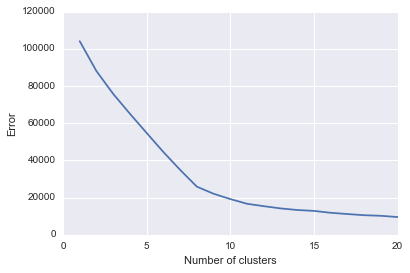

In [368]:
svd = TruncatedSVD(7)
normalizer = Normalizer(copy=False)
lsa = make_pipeline(svd, normalizer)
X = lsa.fit_transform(X)
#explained_variance = svd.explained_variance_ratio_.sum()
#print("Explained variance of the SVD step: {}%".format(int(explained_variance * 100)))

evaluate_clusters(X,20)

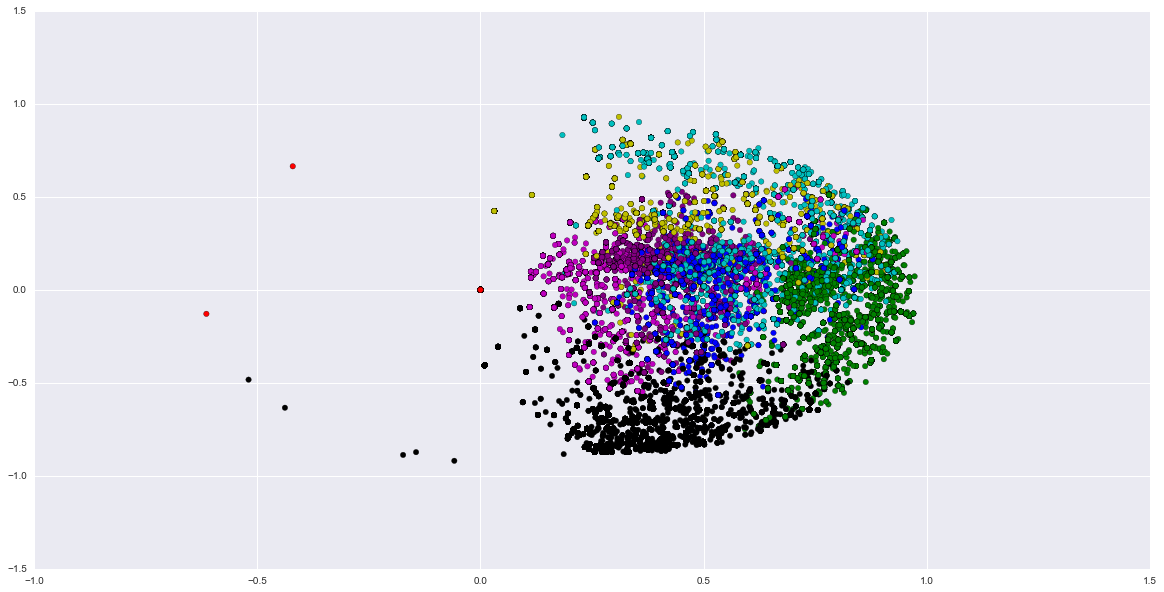

In [369]:
#kmeans = KMeans(n_clusters=12, init='k-means++', max_iter=100, n_init=1, verbose=True)
#y_pred = kmeans.fit(X)
kmeans = MiniBatchKMeans(n_clusters=8, init='k-means++', n_init=1,
                     init_size=1000, batch_size=1000, verbose=False)
#print("Silhouette Coefficient: %0.3f"
#      % metrics.silhouette_score(X, km.labels_, sample_size=1000))

#kmeans = KMeans(init='k-means++', n_clusters=7, n_init=20)
y_pred = kmeans.fit_predict(X)
centroids = kmeans.cluster_centers_
labels = kmeans.labels_
error = kmeans.inertia_
colors = np.array([x for x in ('b', 'g', 'r', 'c', 'm', 'y', 'k', 'purple', 'lime', 'maroon', 'olive', 'pink')])
colors = np.hstack([colors] * 20)

plt.figure(figsize=(20, 10))
plt.scatter(X[:, 0], X[:, 1], s=30, c=colors[y_pred].tolist())
#print "labels:" , labels
#print "error:", error
#print "centroids:", centroids

In [373]:
#from sklearn.metrics import silhouette_samples, silhouette_score
#silh_avg = silhouette_score(X, y_pred)
tags = np.unique(labels)
nonan_tweets_df = tweets_df.dropna()
nonan_tweets_df['Labels'] = pd.Series(labels, index=nonan_tweets_df.index)
#print nonan_tweets_df.info()
grouped = nonan_tweets_df.groupby('Labels')
print grouped.size()
raw_clusters = []
pop_users = []
clusters = []
for t in tags:
    g = pd.DataFrame(grouped.get_group(t))
    raw_clusters.append(g)
    #pop_users.append(pd.DataFrame(grouped.get_group(t)).sort_values("Popularity", ascending=False)[:5])

for c in raw_clusters:
    byUsers = pd.DataFrame(c.groupby('User ID').sum().sort_values('Popularity', ascending=False))
    clusters.append(byUsers)
    pop_users.append(byUsers[:3])

Labels
0    13384
1    20175
2    84950
3    23470
4    16640
5    21671
6    14367
7    11615
dtype: int64


/Users/Minying/envs/cs591-datamining/lib/python2.7/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [374]:
top_users = []
for p in pop_users:
    print p.index.values[:3]
    top_users.append(int(p.index.values[0]))
    top_users.append(int(p.index.values[1]))
    top_users.append(int(p.index.values[2]))
    
top_users = np.unique(top_users)
print top_users

['2421921523' '2376881202' '2781159212']
['2376881202' 2826800366.0 356199261.0]
['1038152798' 2421921523.0 '2421921523']
[14172204.0 246557633.0 '28959261']
['2421921523' '2845238149' '2770741455']
['1265807251' '20066020' '89507141']
[96459347.0 1198804064.0 738809107.0]
['2311435027' 2747504632.0 '2814008060']
[  14172204   20066020   28959261   89507141   96459347  246557633
  356199261  738809107 1038152798 1198804064 1265807251 2311435027
 2376881202 2421921523 2747504632 2770741455 2781159212 2814008060
 2826800366 2845238149]


In [375]:
twitter = Twython(CONSUMER_KEY, CONSUMER_SECRET, OAUTH_TOKEN, OAUTH_TOKEN_SECRET)
top_obj = get_user_lookup(twitter, top_users.tolist())
for o in top_obj:
    print o['id'], o['followers_count']

14172204 204
20066020 208
28959261 77
89507141 784
96459347 216
246557633 197
356199261 358
738809107 228
1038152798 118
1198804064 9
1265807251 68
2311435027 1679
2376881202 580
2421921523 1850
2747504632 1604
2770741455 867
2781159212 233
2814008060 674
2826800366 993
2845238149 1074


In [376]:
follower_ids = defaultdict(list)

remaining = twitter.get_application_rate_limit_status()['resources']['followers']['/followers/ids']['remaining']
for u in top_users[1:].tolist():
    print remaining
    if remaining < 2:
        print "start waiting ", u
        time.sleep(920)
        print "done waiting"
        
    twitter = Twython(CONSUMER_KEY, CONSUMER_SECRET, OAUTH_TOKEN, OAUTH_TOKEN_SECRET)
    print u
    follower_ids[u] = test(twitter, u)
    twitter = Twython(CONSUMER_KEY, CONSUMER_SECRET, OAUTH_TOKEN, OAUTH_TOKEN_SECRET)
    remaining = twitter.get_application_rate_limit_status()['resources']['followers']['/followers/ids']['remaining']
    print follower_ids.keys()


15
20066020
14
[20066020]
14
28959261
13
[20066020, 28959261]
13
89507141
12
[20066020, 28959261, 89507141]
12
96459347
11
[96459347, 20066020, 28959261, 89507141]
11
246557633
10
[246557633, 96459347, 20066020, 28959261, 89507141]
10
356199261
9
[246557633, 20066020, 89507141, 356199261, 96459347, 28959261]
9
738809107
8
[246557633, 20066020, 89507141, 738809107, 356199261, 96459347, 28959261]
8
1038152798
7
[246557633, 20066020, 89507141, 738809107, 356199261, 96459347, 28959261, 1038152798]
7
1198804064
6
[1198804064, 246557633, 20066020, 89507141, 738809107, 356199261, 96459347, 28959261, 1038152798]
6
1265807251
5
[1198804064, 246557633, 20066020, 89507141, 738809107, 356199261, 96459347, 1265807251, 28959261, 1038152798]
5
2311435027
4
[1198804064, 246557633, 20066020, 89507141, 738809107, 356199261, 96459347, 2311435027, 1265807251, 28959261, 1038152798]
4
2376881202
3
[1198804064, 246557633, 20066020, 89507141, 738809107, 356199261, 2376881202, 96459347, 2311435027, 1265807251,

In [377]:
print follower_ids[175378976]

[]


In [378]:
len(follower_ids.keys())
for k in follower_ids.keys():
    print k, len(follower_ids[k])

1198804064 9
246557633 197
20066020 208
89507141 784
738809107 228
2814008060 674
2781159212 233
175378976 0
2826800366 993
356199261 358
2747504632 1604
2376881202 580
96459347 216
2421921523 1850
2311435027 1679
2770741455 867
1265807251 68
28959261 77
1038152798 118
2845238149 1074


In [379]:
for p in pop_users:
    _curr = []
    for u in p.index.values:
        print u, len(follower_ids[int(u)])
        _curr.append(follower_ids[int(u)])
    #print len(_curr)
    p['follower_ids'] = np.array(_curr)
    print p.info()

2421921523 1850
2376881202 580
2781159212 233
<class 'pandas.core.frame.DataFrame'>
Index: 3 entries, 2421921523 to 2781159212
Data columns (total 8 columns):
Retweets        3 non-null float64
Favorites       3 non-null float64
Has_url         3 non-null float64
Polarity        3 non-null float64
Popularity      3 non-null float64
numMentions     3 non-null float64
Labels          3 non-null int32
follower_ids    3 non-null object
dtypes: float64(6), int32(1), object(1)
memory usage: 204.0+ bytes
None
2376881202 580
2826800366.0 993
356199261.0 358
<class 'pandas.core.frame.DataFrame'>
Index: 3 entries, 2376881202 to 356199261.0
Data columns (total 8 columns):
Retweets        3 non-null float64
Favorites       3 non-null float64
Has_url         3 non-null float64
Polarity        3 non-null float64
Popularity      3 non-null float64
numMentions     3 non-null float64
Labels          3 non-null int32
follower_ids    3 non-null object
dtypes: float64(6), int32(1), object(1)
memory usage:

/Users/Minying/envs/cs591-datamining/lib/python2.7/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [384]:
print pop_users[0].follower_ids
print len(pop_users)

User ID
2421921523    [719651928075059200, 702724379289882627, 71680...
2376881202    [3490688292, 723398056134070272, 3347554983, 1...
2781159212    [4591018393, 18548136, 599777096, 557265175, 2...
Name: follower_ids, dtype: object
8


In [292]:
nonan_tweets_df.to_csv("clustered_tweets.csv", sep="\t", encoding='utf-8')

In [386]:
all_pop_users = pd.concat([x for x in pop_users], ignore_index=False)
#print all_pop_users.info()
print len(clusters)

<class 'pandas.core.frame.DataFrame'>
Index: 24 entries, 2421921523 to 2814008060
Data columns (total 10 columns):
Retweets                24 non-null float64
Favorites               24 non-null float64
Has_url                 24 non-null float64
Polarity                24 non-null float64
Popularity              24 non-null float64
numMentions             24 non-null float64
Labels                  24 non-null int32
follower_ids            24 non-null object
Followers In Cluster    24 non-null object
Followers In df         24 non-null object
dtypes: float64(6), int32(1), object(3)
memory usage: 2.0+ KB
None
8


In [297]:
all_pop_users.to_csv("all_pop_users.csv", sep="\t", encoding='utf-8')

In [387]:
all_users = set(nonan_tweets_df['User ID'].tolist())

for i in range(len(pop_users)):
    F_IN_C = []
    F_IN_DF = []
    followers = pop_users[i]['follower_ids'].tolist()
    cluster_users = set(clusters[i].index.tolist())
    for fol in followers:
        f_in_df = []
        f_in_cluster = []
        for f in fol:
            if f in cluster_users:
                f_in_cluster.append(f)

            if f in all_users:
                f_in_df.append(f)
        
        F_IN_C.append(f_in_cluster)
        F_IN_DF.append(f_in_df)
    
    pop_users[i]['Followers In Cluster'] = F_IN_C
    pop_users[i]['Followers In df'] = F_IN_DF

print pop_users[0].info()
print pop_users[-1].info()

/Users/Minying/envs/cs591-datamining/lib/python2.7/site-packages/ipykernel/__main__.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Minying/envs/cs591-datamining/lib/python2.7/site-packages/ipykernel/__main__.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


<class 'pandas.core.frame.DataFrame'>
Index: 3 entries, 2421921523 to 2781159212
Data columns (total 10 columns):
Retweets                3 non-null float64
Favorites               3 non-null float64
Has_url                 3 non-null float64
Polarity                3 non-null float64
Popularity              3 non-null float64
numMentions             3 non-null float64
Labels                  3 non-null int32
follower_ids            3 non-null object
Followers In Cluster    3 non-null object
Followers In df         3 non-null object
dtypes: float64(6), int32(1), object(3)
memory usage: 252.0+ bytes
None
<class 'pandas.core.frame.DataFrame'>
Index: 3 entries, 2311435027 to 2814008060
Data columns (total 10 columns):
Retweets                3 non-null float64
Favorites               3 non-null float64
Has_url                 3 non-null float64
Polarity                3 non-null float64
Popularity              3 non-null float64
numMentions             3 non-null float64
Labels           

In [388]:
for p in pop_users:
    ratios = []
    counts = []
    for i in range(len(p)):
        r = len(p['Followers In Cluster'][i]) * 1.0 / len(p['Followers In df'][i])
        c = len(p['follower_ids'][i])
        ratios.append(r)
        counts.append(c)
    p['Ratio'] = ratios
    p['follower_count'] = counts


/Users/Minying/envs/cs591-datamining/lib/python2.7/site-packages/ipykernel/__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Minying/envs/cs591-datamining/lib/python2.7/site-packages/ipykernel/__main__.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


ZeroDivisionError: float division by zero

In [351]:
for p in pop_users:
    for i in p:

TypeError: string indices must be integers, not str

In [392]:
print nonan_tweets_df.loc[nonan_tweets_df['User ID'].isin(all_pop_users.index.tolist())].groupby('User ID').sum()

              Retweets  Favorites  Has_url  Polarity  Popularity  numMentions  \
User ID                                                                         
14172204.0        7711          0        1    0.3710        7711            3   
96459347.0        3468          0        2    0.4190        3468            8   
246557633.0       7709          0        0    0.8980        7709            1   
356199261.0      12514          7       38   54.1130       12521          352   
738809107.0       3299          0        0    0.0000        3299            3   
1198804064.0      3299          0        0    0.6130        3299            3   
2421921523.0     21027         13      101   87.1797       21040          551   
2747504632.0     10681          0       18   37.6636       10681          190   
2826800366.0     17486          5       39   55.5863       17491          280   
1038152798       19637          2       95   97.6197       19639          538   
1265807251       12132      

In [401]:
print nonan_tweets_df.groupby('User ID').size().sort_values(ascending=False) #sum().sort_values('Popularity', ascending=False)[:50]

User ID
2791121294.0    973
2791121294      945
2807060009.0    648
2807060009      523
2421921523      500
2845238149      476
183993932.0     442
1132062200      439
1038152798      405
2421921523.0    401
112614146       371
2702828160      366
500240347.0     359
29431077        337
2814040284      334
2814040284.0    329
289490370       323
1038152798.0    309
2806977060      301
29431077.0      300
2563030626      293
1132062200.0    291
465606946       289
18746944        287
2757067388      285
2837175356.0    282
1335585896.0    279
2311435027      274
16710197        270
112614146.0     268
               ... 
16035833          1
15975240          1
15973905          1
15972656          1
1594548300        1
1591741910        1
1592191417        1
15922626          1
15932984          1
15934944          1
15934978          1
15938085          1
15941144          1
15942753          1
159443501         1
15944905          1
15946657          1
1597105992        1
15947248    